# CEIA FIUBA LSE
- **Materia**: NLP
- **Cohorte**: 16
- **Alumno**: Federico Arias Suarez
- Desafio # 3

# Consigna:
Utilizar otro dataset y poner en práctica la predicción de próxima palabra

El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

**Detalle Consigna:**
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

Para el desafio vamos a usar el dataset:

https://www.kaggle.com/datasets/psyflow/reddit-conversation-dataset

Que consiste en comentarios en Reddit

# Subir kaggle.json a Google Colab:

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"federicoa92","key":"4313b70cdf8f3f78608e81df85d29b83"}'}

In [ ]:
import os
import zipfile

# Mueve kaggle.json a la carpeta de configuración de Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Cambia los permisos del archivo


# Descargar el dataset:

In [ ]:
# Descarga el dataset de Kaggle
!kaggle datasets download -d psyflow/reddit-conversation-dataset

Dataset URL: https://www.kaggle.com/datasets/psyflow/reddit-conversation-dataset
License(s): unknown
100% 2.50G/2.51G [00:33<00:00, 137MB/s]
100% 2.51G/2.51G [00:33<00:00, 79.4MB/s]


In [ ]:
# Descomprime el archivo descargado
with zipfile.ZipFile("reddit-conversation-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("reddit_conversations")


In [ ]:
# Descomprimimos:
import tarfile

# Descomprime el archivo .tgz
tgz_path = "reddit_conversations/reddit_conversations_v1.0_3turns.topical.tgz"
with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall("reddit_conversations_extracted")

# Ahora puedes explorar los archivos extraídos


In [ ]:
# Ruta al archivo de texto
file_path = "reddit_conversations_extracted/reddit_conversations.3turns.train.topical.txt"

corpus = []
#El dataset es MUY grande y siempre colapsa la RAM, asi que vamos a cargar los datos hasta un limite
max_lines = 900  # Define el número máximo de líneas (ajusta según tu RAM)
max_length = 10**6  # Define la longitud máxima del texto en caracteres (ajusta según tu RAM)
current_length = 0  # Inicializa el contador de longitud

with open(file_path, 'r') as f:
    for line in f:
        if len(corpus) >= max_lines or current_length >= max_length:
            break  # Detén la carga si alcanzas el límite de líneas o longitud
        line = line.strip()
        corpus.append(line)
        current_length += len(line)

# corpus es ahora una lista de líneas, con un tamaño limitado
# Puedes concatenar las líneas si necesitas una sola cadena:
full_text = " ".join(corpus)

# Ver una muestra del corpus
print(corpus[:5])  # Muestra las primeras 5 líneas
print(f"Total de líneas cargadas: {len(corpus)}")
print(f"Tamaño total del texto: {current_length} caracteres")


['if it were just the top line i \'d give it a thumbs up . no tastiness . no 50 shades of grey thank you .\ti really like " steel encased in velvet " as a simile to be fair .\tbut is it an apt description of hard - on in your mouth ?\tlooks like look good love thanks nice great beautiful awesome amazing thank looking cake cool ve man wow bear pretty haha lol right url re know ll damn work job sure got seen kind way picture think happy definitely bears best dude time thing yeah perfect thought better looked gorgeous sweet glad sharing want actually holy makes favorite sounds going hey reminds fantastic hope recipe super incredible pic absolutely delicious making people yes god shit try style kinda maybe tell lovely little probably find face idea sorry feel share day cute enjoy jealous mind post fucking seeing edit need photo', "if they stopped selling plastic bottles then people would bring their own bottles as like everyone takes water to the park no ?\thow about selling non plastic bo

# Preprocesamiento:
- Hay que transformar las oraciones en tokens. Haremos tokenizacion a nivel caracter.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [ ]:
# Como queremos predecir a nivel de caracteres, primero crearemos un vocabulario con los caracteres únicos en el full_text.
# Extrae los caracteres únicos y crea un vocabulario
unique_chars = sorted(set(full_text))
char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
idx_to_char = {idx: char for idx, char in enumerate(unique_chars)}

# Convierte el texto completo a una lista de índices (tokenización por caracteres)
text_as_int = [char_to_idx[char] for char in full_text]

# Verifica la longitud del vocabulario y algunos ejemplos
vocab_size = len(unique_chars)
print(f"Tamaño del vocabulario (caracteres únicos): {vocab_size}")
print(f"Ejemplo de índices: {text_as_int[:100]}")


Tamaño del vocabulario (caracteres únicos): 69
Ejemplo de índices: [47, 44, 3, 47, 58, 3, 61, 43, 56, 43, 3, 48, 59, 57, 58, 3, 58, 46, 43, 3, 58, 53, 54, 3, 50, 47, 52, 43, 3, 47, 3, 10, 42, 3, 45, 47, 60, 43, 3, 47, 58, 3, 39, 3, 58, 46, 59, 51, 40, 57, 3, 59, 54, 3, 17, 3, 52, 53, 3, 58, 39, 57, 58, 47, 52, 43, 57, 57, 3, 17, 3, 52, 53, 3, 24, 19, 3, 57, 46, 39, 42, 43, 57, 3, 53, 44, 3, 45, 56, 43, 63, 3, 58, 46, 39, 52, 49, 3, 63, 53]


Vamos a definir un flujo de trabajo *many to many* tal que para cada secuencia de entrada de longitud m, el modelo también aprenda y predecir una secuencia de salida de longitud n. Esto significa que el modelo aprende a generar varios caracteres en la salida, no solo uno.

In [ ]:
# Definiremos las secuencias de entrada y salida basándonos en los valores de m=25 y n=15.
# Usaremos ventanas deslizantes para crear cada secuencia de entrada de 25 caracteres y
# una secuencia de salida de 15 caracteres, moviendo una posición a la vez para maximizar el número de pares.

m = 10  # Longitud de la secuencia de entrada: valor quizas no optimo, pero sino se satura la RAM
n = 5  # Longitud de la secuencia de salida: valor quizas no optimo, pero sino se satura la RAM

# Prepara las secuencias de entrada y salida
input_sequences = []
output_sequences = []

for i in range(0, len(text_as_int) - m):
    # Secuencia de entrada de 'm' caracteres
    input_seq = text_as_int[i : i + m]
    # Secuencia de salida de 'n' caracteres justo después de la entrada
    output_seq = text_as_int[i + 1 : i + m + n]  # Desplaza la salida en n respecto a la entrada

    input_sequences.append(input_seq)
    output_sequences.append(output_seq)

# Muestra algunos ejemplos
print(f"Número total de secuencias de entrada: {len(input_sequences)}")
print("Ejemplo de secuencia de entrada:", input_sequences[1])
print("Ejemplo de secuencia de salida:", output_sequences[1])


Número total de secuencias de entrada: 735584
Ejemplo de secuencia de entrada: [44, 3, 47, 58, 3, 61, 43, 56, 43, 3]
Ejemplo de secuencia de salida: [3, 47, 58, 3, 61, 43, 56, 43, 3, 48, 59, 57, 58, 3]


Vemos que para cada secuencia, el output_sequences nos entrega los siguientes 10 caracteres.

# Definimos el Dataset

In [11]:
# Asegúrate de que cada secuencia de salida tenga la misma longitud que m
output_sequences = [seq[:m] for seq in output_sequences]  # Trunca o asegura longitud uniforme

# Convertir `input_sequences` y `output_sequences` a arrays de NumPy
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

print("Shape de input_sequences:", input_sequences.shape)
print("Shape de output_sequences:", output_sequences.shape)


Shape de input_sequences: (735584, 10)
Shape de output_sequences: (735584, 10)


In [21]:
from tensorflow.keras.utils import to_categorical

# Convertir `input_sequences` y `output_sequences` a NumPy arrays
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

# Tamaño del vocabulario
vocab_size = len(char_to_idx)

# Crear un Dataset de TensorFlow
dataset = tf.data.Dataset.from_tensor_slices((input_sequences, output_sequences))

# Función para aplicar `to_categorical` a `output_sequences` en cada lote
def process_output(x, y):
    y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)
    return x, y

# Aplicar el procesamiento por lotes
batch_size = 128
dataset = dataset.batch(batch_size, drop_remainder=True).map(process_output).prefetch(tf.data.AUTOTUNE)

# Dividir el dataset en entrenamiento y validación
train_size = int(0.8 * len(input_sequences))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


# Definir la Arquitectura de la RNN con LSTM

- **Capa Embedding**: Transformará los índices de caracteres en vectores densos, facilitando que el modelo aprenda relaciones entre caracteres.
- **Capas LSTM**: Utilizaremos una o más capas LSTM para capturar la secuencia temporal. Las LSTM son adecuadas aquí debido a su capacidad de recordar información a largo plazo, útil para secuencias de texto.
- **Capa Densa de Salida**: Finalmente, una capa densa con activación softmax producirá una distribución de probabilidad sobre los caracteres del vocabulario, permitiendo que el modelo prediga cada carácter en la secuencia de salida.

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed

vocab_size = len(char_to_idx)  # Tamaño del vocabulario
embedding_dim = 64
lstm_units = 200

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=m),
    LSTM(units=lstm_units, return_sequences=True),
    LSTM(units=lstm_units, return_sequences=True),
    TimeDistributed(Dense(units=vocab_size, activation='softmax'))
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Entrena el modelo y almacena el objeto history
history = model.fit(
    train_dataset,
#    validation_data=val_dataset,
    epochs=1  # Ajusta el número de épocas según sea necesario
)

5746/5746 ━━━━━━━━━━━━━━━━━━━━ 1037s 180ms/step - accuracy: 0.5130 - loss: 1.5419


Perplejidad de entrenamiento por época: [4.61290618]


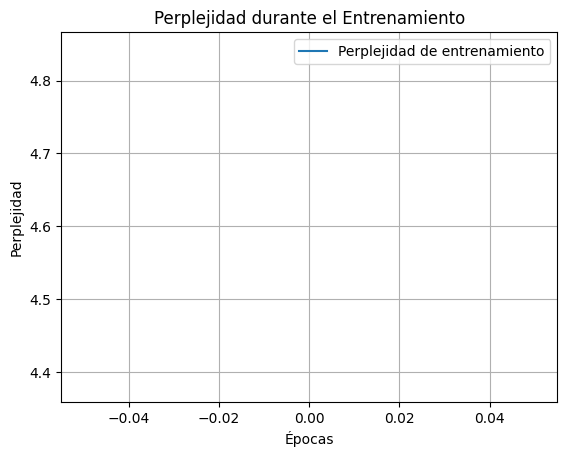

In [37]:
# Graficamos perplejidad:
# Calcula la perplejidad para entrenamiento y validación usando el historial de pérdidas
train_perplexities = np.exp(history.history['loss'])
#val_perplexities = np.exp(history.history['val_loss'])

# Imprime y guarda las perplejidades
print("Perplejidad de entrenamiento por época:", train_perplexities)
#print("Perplejidad de validación por época:", val_perplexities)

# Graficar la perplejidad
plt.plot(train_perplexities, label='Perplejidad de entrenamiento')
#plt.plot(val_perplexities, label='Perplejidad de validación')
plt.xlabel("Épocas")
plt.ylabel("Perplejidad")
plt.legend()
plt.title("Perplejidad durante el Entrenamiento")
plt.grid()
plt.show()

In [39]:
# Guarda el modelo completo
model.save("mi_modelo.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Carga el modelo completo
loaded_model = load_model("nombre_del_modelo.keras")


# Predecimos la siguiente secuencia de caracteres:

In [23]:
def predict_next_chars(model, seed_text, char_to_idx, idx_to_char, n_chars=15):
    # Convierte el texto de entrada en una lista de índices
    input_indices = [char_to_idx[char] for char in seed_text if char in char_to_idx]

    # Asegura que el input sea de longitud `m` para el modelo (completa con espacios si es más corto)
    if len(input_indices) < m:
        input_indices = [char_to_idx[' ']] * (m - len(input_indices)) + input_indices
    else:
        input_indices = input_indices[-m:]

    # Convierte el input en un array de forma (1, m) para que el modelo lo procese
    input_array = np.array(input_indices).reshape(1, -1)

    # Genera los siguientes caracteres
    generated_text = seed_text
    for _ in range(n_chars):
        predictions = model.predict(input_array, verbose=0)

        # Selecciona el índice de mayor probabilidad para el próximo carácter
        next_index = np.argmax(predictions[0, 0])
        next_char = idx_to_char[next_index]

        # Añade el nuevo carácter al texto generado
        generated_text += next_char

        # Actualiza el array de input para la próxima predicción
        input_indices = input_indices[1:] + [next_index]
        input_array = np.array(input_indices).reshape(1, -1)

    return generated_text

In [43]:
# Prueba con las frases proporcionadas
print(predict_next_chars(model, "Are you", char_to_idx, idx_to_char, n_chars=15))
print(predict_next_chars(model, "Advice ", char_to_idx, idx_to_char, n_chars=15))
print(predict_next_chars(model, "How", char_to_idx, idx_to_char, n_chars=15))


Are youtttte t nr     
Advice tttt eno t    t
Howttttttttna     


In [44]:
print(predict_next_chars(model, "Would ", char_to_idx, idx_to_char, n_chars=4))
print(predict_next_chars(model, "How does one", char_to_idx, idx_to_char, n_chars=5))
print(predict_next_chars(model, "Did she", char_to_idx, idx_to_char, n_chars=5))


Would tttt
How does oneat n 
Did shettttn


Vemos que siempre predice `the the the the`

Algunas opciones para solucionar esto son:

1. Reintroducir Muestreo con Temperatura
La falta de variabilidad en los caracteres puede solucionarse aplicando muestreo estocástico con temperatura, lo que permite generar predicciones menos deterministas.
2. Entrenar el Modelo con Más Épocas o Ajustar el Modelo
Si el modelo no ha captado patrones más complejos, podrías mejorar los resultados entrenándolo con más épocas o aumentando la complejidad del modelo (más unidades LSTM o capas). Sin embargo, esto requerirá más recursos y tiempo de entrenamiento.